In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns
from IPython.display import display,Image
from collections import Counter

%matplotlib inline
sns.set(style = 'white', context = 'notebook', palette = 'deep')

import matplotlib.style as style
style.use('fivethirtyeight')
import time

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [63]:
df = pd.read_csv('../nyc-rolling-sales.csv',index_col=0)

## EDA

In [64]:
df_raw = df
print("-------------------------------------------------")
print(df.head())
print("-------------------------------------------------")
print(f"shape of dataset =>{df.shape}")
print("-------------------------------------------------")

-------------------------------------------------
   BOROUGH   NEIGHBORHOOD                      BUILDING CLASS CATEGORY  \
4        1  ALPHABET CITY  07 RENTALS - WALKUP APARTMENTS                
5        1  ALPHABET CITY  07 RENTALS - WALKUP APARTMENTS                
6        1  ALPHABET CITY  07 RENTALS - WALKUP APARTMENTS                
7        1  ALPHABET CITY  07 RENTALS - WALKUP APARTMENTS                
8        1  ALPHABET CITY  07 RENTALS - WALKUP APARTMENTS                

  TAX CLASS AT PRESENT  BLOCK  LOT EASE-MENT BUILDING CLASS AT PRESENT  \
4                   2A    392    6                                  C2   
5                    2    399   26                                  C7   
6                    2    399   39                                  C7   
7                   2B    402   21                                  C4   
8                   2A    404   55                                  C2   

                  ADDRESS APARTMENT NUMBER  ...  RESIDENTIAL

In [65]:
## adding new variables

df['BUILDING_AGE'] = 2022 - df['YEAR BUILT']
print(df['BUILDING_AGE'])


4       122
5       122
6       122
7       109
8       122
       ... 
8409     24
8410     24
8411     97
8412     21
8413     16
Name: BUILDING_AGE, Length: 84548, dtype: int64


In [66]:
df['BOROUGH'] = df['BOROUGH'].map({1:'Manhattan', 2:'Bronx', 3: 'Brooklyn', 4:'Queens',5:'Staten Island'})

In [67]:
# creating year and month column
df['sale_year'] = pd.DatetimeIndex(df['SALE DATE']).year
df['sale_month'] = pd.DatetimeIndex(df['SALE DATE']).month

In [68]:
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'],errors = 'coerce')

In [69]:
numeric = ["RESIDENTIAL UNITS","COMMERCIAL UNITS","TOTAL UNITS", "LAND SQUARE FEET" ,
           "GROSS SQUARE FEET","SALE PRICE" ]

for col in numeric:
    df[col] = pd.to_numeric(df[col],errors = 'coerce')

In [70]:
categorical = ["BOROUGH","NEIGHBORHOOD",'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
               'BUILDING CLASS AT PRESENT','ZIP CODE', 'BUILDING CLASS AT TIME OF SALE', 'TAX CLASS AT TIME OF SALE']

for col in categorical:
    df[col] = df[col].astype(object)

## MISSING VALUE 


In [71]:
df.replace(' ',np.nan, inplace=True)

In [72]:
round(df.isna().sum() /len(df) *100,2)

BOROUGH                             0.00
NEIGHBORHOOD                        0.00
BUILDING CLASS CATEGORY             0.00
TAX CLASS AT PRESENT                0.87
BLOCK                               0.00
LOT                                 0.00
EASE-MENT                         100.00
BUILDING CLASS AT PRESENT           0.87
ADDRESS                             0.00
APARTMENT NUMBER                   77.47
ZIP CODE                            0.00
RESIDENTIAL UNITS                   0.00
COMMERCIAL UNITS                    0.00
TOTAL UNITS                         0.00
LAND SQUARE FEET                   31.05
GROSS SQUARE FEET                  32.66
YEAR BUILT                          0.00
TAX CLASS AT TIME OF SALE           0.00
BUILDING CLASS AT TIME OF SALE      0.00
SALE PRICE                         17.22
SALE DATE                           0.00
BUILDING_AGE                        0.00
sale_year                           0.00
sale_month                          0.00
dtype: float64

In [73]:
print(df[(df['LAND SQUARE FEET'].isnull()) & (df['GROSS SQUARE FEET'].notnull())].shape[0])
print(df[(df['LAND SQUARE FEET'].notnull()) & (df['GROSS SQUARE FEET'].isnull())].shape[0])

6
1366


In [74]:
imputation = df[['LAND SQUARE FEET','GROSS SQUARE FEET']]
imputation[(imputation['LAND SQUARE FEET'].isnull()) & (imputation['GROSS SQUARE FEET'].notnull())]

,LAND SQUARE FEET,GROSS SQUARE FEET
77,NaN,36472.0
1878,NaN,51644.0
2557,NaN,32843.0
10189,NaN,28801.0
5806,NaN,33770.0
5807,NaN,33770.0


In [75]:
imputation.dropna(inplace=True)

In [77]:
#regression model for predicting Gross Square feet
X = imputation['LAND SQUARE FEET']
y = imputation['GROSS SQUARE FEET']

lm = LinearRegression()
model = lm.fit(X.values.reshape(-1,1), y.values.reshape(-1,1))

print("Intercept: ",model.intercept_)
print("Coffecient: ",model.coef_)
print("Regression Model: Y={}+{}X".format(model.intercept_,model.coef_))
print("R-Squared: ", model.score(X.values.reshape(-1,1),y.values.reshape(-1,1)))

Intercept:  [1701.2484797]
Coffecient:  [[0.64815423]]
Regression Model: Y=[1701.2484797]+[[0.64815423]]X
R-Squared:  0.4133841980340115


In [81]:
#regression model for predicting Land Square feet

X = imputation['GROSS SQUARE FEET']
y = imputation['LAND SQUARE FEET']

lm = LinearRegression()

model = lm.fit(X.values.reshape(-1,1), y.values.reshape(-1,1))


print("Intercept: ", model.intercept_)
print("Coffecient: ", model.coef_)
print("Regression Model: Y={}+{}X".format(model.intercept_,model.coef_))
print("R-Squared: ", model.score(X.values.reshape(-1,1),y.values.reshape(-1,1)))

Intercept:  [1033.76397579]
Coffecient:  [[0.63778678]]
Regression Model: Y=[1033.76397579]+[[0.63778678]]X
R-Squared:  0.4133841980340116


In [82]:
def imputer_gross(x):
    return x * 0.64779857 + 1822.76092513

def imputer_land(x):
    return x * 0.6375468 + 1107.3023519

In [83]:
# Imputing missing values of theese columns.

df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].mask((df['LAND SQUARE FEET'].isnull()) & (df['GROSS SQUARE FEET'].notnull()),imputer_land(df['GROSS SQUARE FEET']))
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].mask((df['LAND SQUARE FEET'].notnull()) & (df['GROSS SQUARE FEET'].isnull()),imputer_gross(df['LAND SQUARE FEET']))

In [84]:
df = df[df["SALE PRICE"] > 0]  # Deleting 0 price transfer transactions 
df = df[df["SALE PRICE"].notnull()] # Deleting nan values of dependence variable

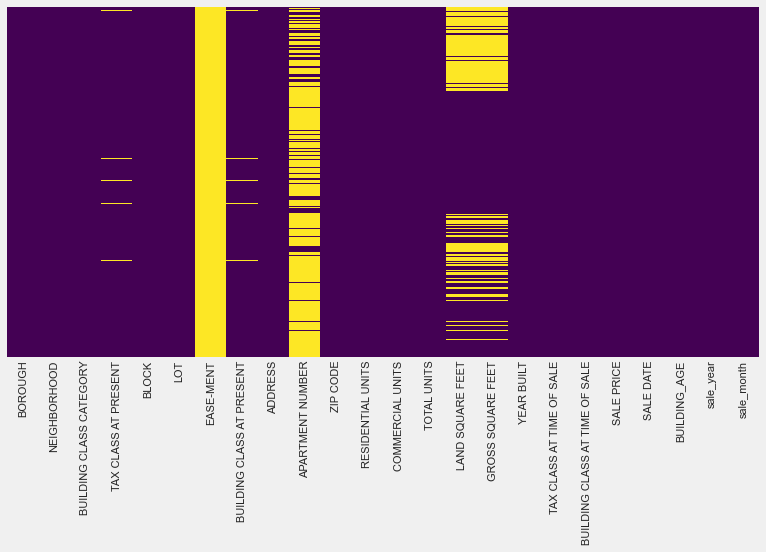

In [85]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [86]:
del df["BUILDING CLASS AT PRESENT"] # It contains the same information with BUILDING CLASS CATEGORY
del df["ADDRESS"] # The variable 1 not required for the model
del df["ZIP CODE"] # The variable 2 not required for the model
del df["SALE DATE"] # We don't need it as we have created the year and month variables.
df.drop(["EASE-MENT","APARTMENT NUMBER"], axis=1, inplace=True) # Completely empty columns.

df = df.dropna() 
df.drop_duplicates(keep = "last", inplace=True)

In [87]:
# Removing data where commercial + residential doesn't equal total units
df = df[df['TOTAL UNITS'] == df['COMMERCIAL UNITS'] + df['RESIDENTIAL UNITS']]

In [88]:
df[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)


,TOTAL UNITS,SALE PRICE
1,1,17768
2,2,10182
0,0,4268
3,3,2954
4,4,801
...,...,...
110,143,1
111,145,1
112,146,1
115,155,1


In [89]:
# Removing rows with TOTAL UNITS == 0 and one outlier with 2261 units
df = df[(df['TOTAL UNITS'] > 0) & (df['TOTAL UNITS'] != 2261)]

In [90]:
df = df[df['YEAR BUILT'] != 0]
del df['YEAR BUILT']

In [92]:
# Square feet should not be 0.
df = df[df["LAND SQUARE FEET"] != 0]
df = df[df["GROSS SQUARE FEET"] != 0]

In [93]:
df.shape

(29262, 17)